In [91]:
import pandas as pd
import io

import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import monai
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
from itkwidgets import view

import torch

from scipy import ndimage

from collections import defaultdict
import cv2

import plotly.express as px

In [2]:
data_npz = "/home/bryan/data/brain_tumor/caidm_3d_96/data.npz"

In [3]:
def load_data(data_npz):
    data = np.load(data_npz)
    return {k:v for k,v in data.items()}

In [4]:
data = load_data(data_npz)

In [5]:
for k,v in data.items():
    print(k,v.dtype)

t2w float32
fla float32
t1w float32
t1c float32
tum uint8
lbl int64


In [6]:
data["tum"].shape

(565, 48, 96, 96, 1)

In [6]:
tumor_df = pd.DataFrame({
    "patient": np.arange(len(data["lbl"])),
    "methylation": data["lbl"].flatten().astype(bool)
    
})

In [8]:
tumor_df["tumor_volume"] = np.count_nonzero(data["tum"], axis=(1,2,3,4)) # number of tumor pixels in 3d volume

In [9]:
total_pixels = np.prod(data["tum"].shape[1:]) # total pixels in the 3d volume

In [10]:
tumor_df["tumor_volume_rel_%"] = 100 * tumor_df["tumor_volume"] / total_pixels

In [11]:
# maybe make 
data["tum"].shape

(565, 48, 96, 96, 1)

In [12]:
tumor_area = np.count_nonzero(data["tum"], axis=(2,3,4))

In [13]:
tumor_df["tumor_area_max"] = np.max(tumor_area, axis=1) # 2D slice max

In [14]:
tumor_df["tumor_area_max_slice"] = np.argmax(tumor_area, axis=1)

In [15]:
def add_center_of_mass(df, data_tumor):
    # data_tumor is NDHWC
    slice_centers = []
    h_centers = []
    w_centers = []
    for patient_i in range(len(data_tumor)):
        if df["tumor_volume"][patient_i] == 0:
            slice_centers.append(0)
            h_centers.append(0)
            w_centers.append(0)
        else:
            slice_center, h_center, w_center = ndimage.center_of_mass(data_tumor[patient_i, ..., 0])
            slice_centers.append(slice_center)
            h_centers.append(h_center)
            w_centers.append(w_center)
    df["tumor_center_of_mass_slice"] = slice_centers
    df["tumor_center_of_mass_H"] = h_centers
    df["tumor_center_of_mass_W"] = w_centers
    return df

In [16]:
tumor_df = add_center_of_mass(tumor_df, data["tum"])

In [64]:
ax.set_xl

Object `ax.xlabel` not found.


In [78]:
modality2name = {
    "fla": "FLAIR", #"Fluid Attenuated\nInversion Recovery\n(FLAIR)",
    "t1w": "T1-Weighted Pre-contrast\n(T1w)",
    "t1c": "T1-Weighted Post-contrast\n(T1Gd)",
    "t2w": "T2-Weighted (T2)",
}
def plot_center_of_mass(ax, df, data, patient_i, modality="t2w", xlabel=False):
    row = df.iloc[patient_i]
    s = int(np.round(row["tumor_center_of_mass_slice"]))
    h = row["tumor_center_of_mass_H"]
    w = row["tumor_center_of_mass_W"]
    
    image = blend_images(
        # convert from BDHWC to HWC CHW where C=1, and D=48 3D depth channels
        image=np.transpose(data[modality][patient_i,s,...], axes=(2, 0, 1)), 
        label=np.transpose(data["tum"][patient_i,s,...], axes=(2, 0, 1)),
        alpha=0.25,
        cmap="hsv",
        rescale_arrays=True
    )
    ax.scatter([w], [h], marker="o", s=50, c="yellow")
    ax.imshow(np.moveaxis(image, 0, -1))
    title = f"Patient {patient_i} Slice {s}"
    if xlabel:
        ax.set_xlabel(title, fontsize=20)
    else:
        ax.set_title(title, fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])

def plot_center_of_mass_grid(
    df, data, modality="t2w",
    num_patients=None, patient_range=None,
    filename=None,
):
    if filename is None:
        plt.ion()
    else:
        plt.ioff()
    ncols = 3
    num_patients = len(df)
    num_patients = len(df) if num_patients is None else num_patients
    if patient_range is None:
        patient_range = range(num_patients)
    else:
        num_patients = len(patient_range)

    nrows = int(np.ceil(num_patients / ncols))
    size_factor = 5
    fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=(ncols*size_factor, nrows*size_factor))

    modname = modality2name[modality]
    fig.suptitle(
        f"{modname} MRI with tumor segmentation and center point\n" \
        "Slice selected by center of mass",
        fontsize=20
    )
    for patient_i in patient_range:
        row = int(patient_i / ncols)
        col = patient_i % ncols
        plot_center_of_mass(axes[row, col], df, data, patient_i, modality)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    if filename is not None:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.savefig(filename, format="png")


def plot_center_of_mass_modality_grid(
    df, data,
    num_patients=None,
    patient_range=None,
    filename=None,
):
    if filename is None:
        plt.ion()
    else:
        plt.ioff()
    ncols = 4
    num_patients = len(df)
    num_patients = len(df) if num_patients is None else num_patients
    if patient_range is None:
        patient_range = range(num_patients)
    else:
        num_patients = len(patient_range)

    nrows = num_patients
    size_factor = 5
    fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=(ncols*size_factor, nrows*size_factor))

    fig.suptitle(
        f"MRI with tumor segmentation and center point\n" \
        "Slice selected by center of mass",
        fontsize=24
    )
    for row, patient_i in enumerate(patient_range):
#         axes[row, 0].set_ylabel(f"Patient {patient_i}", rotation=0, size="large")
        for col, modality in enumerate(modality2name.keys()):
            plot_center_of_mass(axes[row, col], df, data, patient_i, modality, xlabel=True)
            if row == 0:
                ax = axes[row, col]
                modname = modality2name[modality]
                ax.set_title(modname, fontsize=22)
#                 patient_title = ax.get_title()
#                 col_title = r'\fontsize{20pt}{3em}\selectfont{}{Modality Name\r}'

    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    if filename is not None:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.savefig(filename, format="png")
    
def plot_center_of_mass_patient(df, data, modality="t2w", patient=0, filename=None):
    if filename is None:
        plt.ion()
    else:
        plt.ioff()
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    modname = modality2name[modality]
    fig.suptitle(f"{modname} MRI", fontsize=14)
    plot_center_of_mass(ax, df, data, patient, modality)
    if filename is not None:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.savefig(filename, format="png")
    return fig, ax

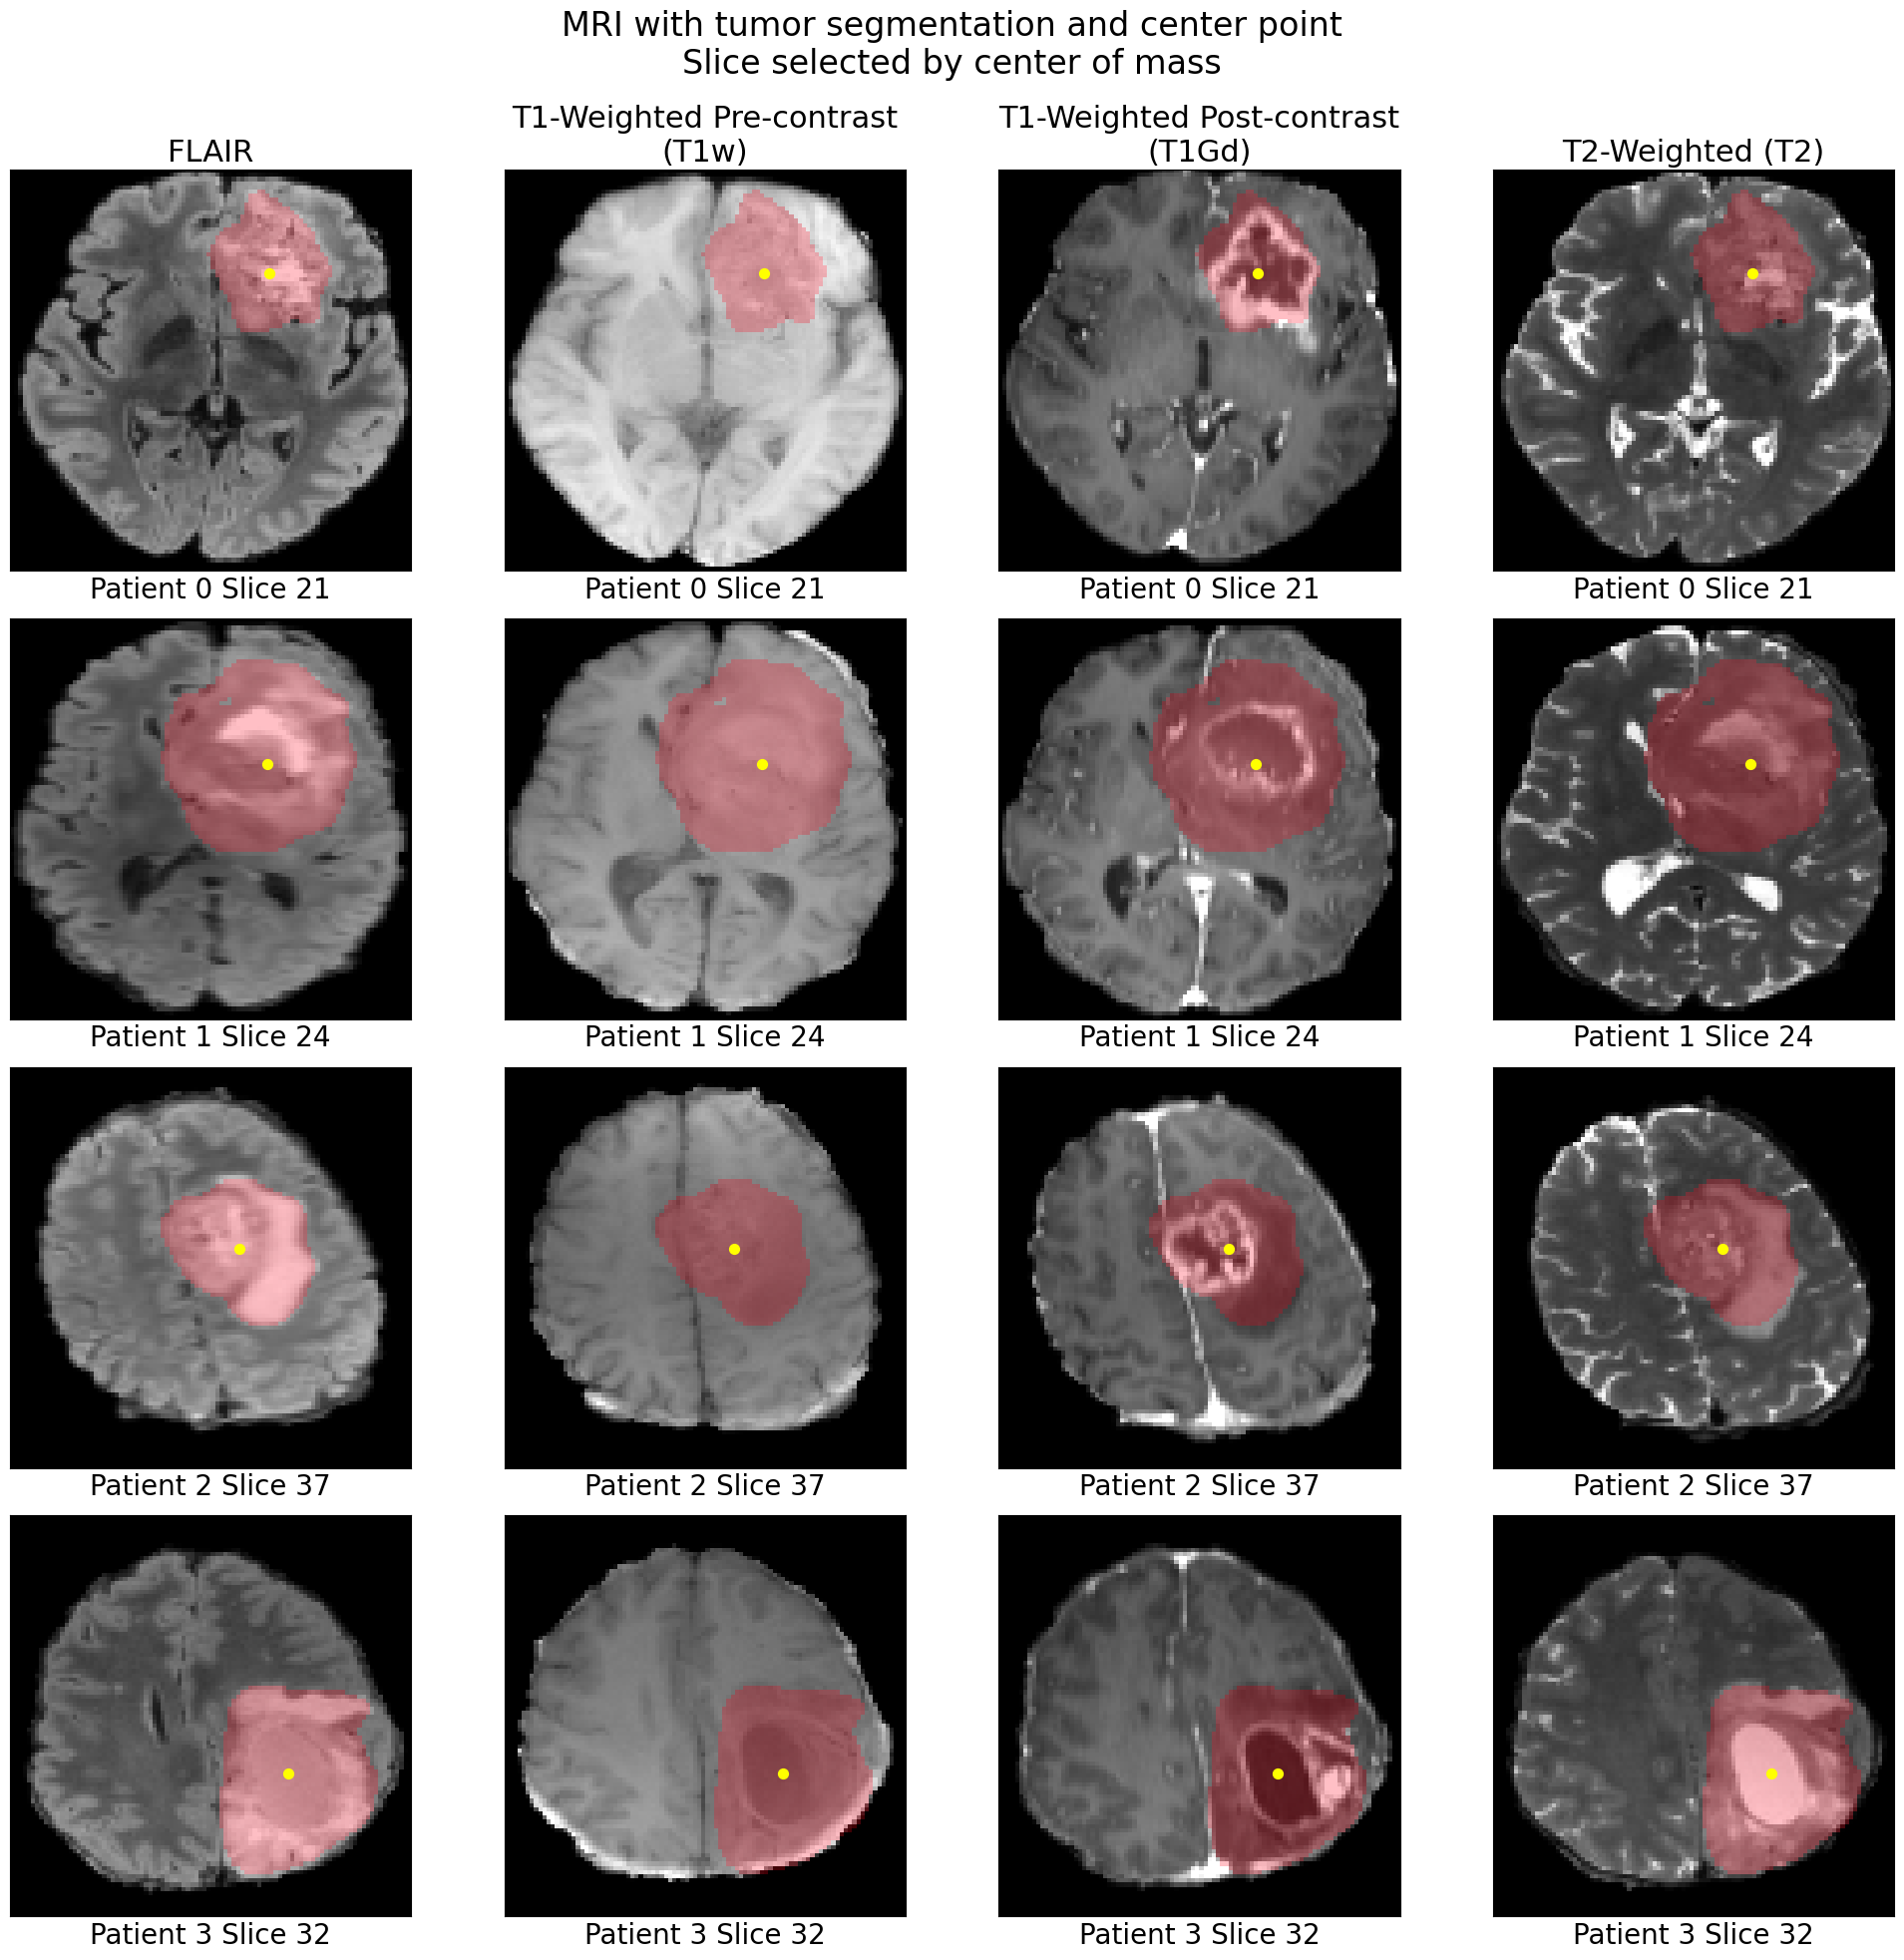

In [79]:
plot_center_of_mass_modality_grid(
    tumor_df,
    data,
    patient_range=range(0,4),
)

In [82]:
p_first = 0
p_last = 3
f"cm-slice-patient-{p_first:04d}-{p_last:04d}.png"

'cm-slice-patient-0000-0003.png'

In [83]:
output_dir="/home/bryan/gdrive/Radiology-Research/brain_tumor/tumor-statistic-report"
patient_range = list(range(0, 4))
def make_filename(output_dir, patient_range):
    p_first = patient_range[0]
    p_last = patient_range[-1]
    file = f"cm-slice-patient-{p_first:04d}-{p_last:04d}.png"
    filename = os.path.join(output_dir, file)
    return filename

plot_center_of_mass_modality_grid(
    tumor_df,
    data,
    patient_range=patient_range,
    filename=make_filename(output_dir,  patient_range)
)

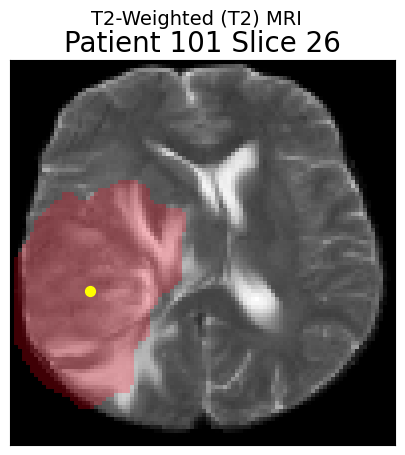

In [115]:
fig, ax = plot_center_of_mass_patient(
    tumor_df, data, patient=101,
    modality="t2w"
)

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Patient 101 Slice 26'}>)

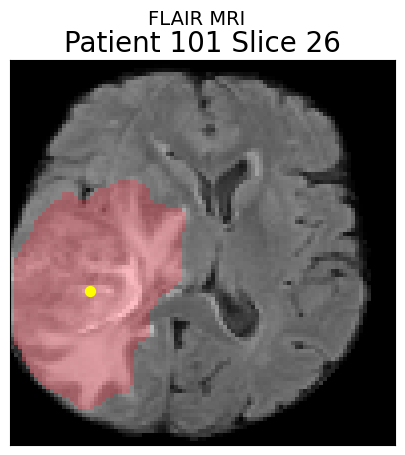

In [116]:
plot_center_of_mass_patient(
    tumor_df, data, patient=101,
    modality="fla"
#     filename="/home/bryan/gdrive/Radiology-Research/brain_tumor/tumor-statistic-report/com-slice-t2w-patient101.png"
)

In [ ]:
tumor_df

In [20]:
def add_tumor_quadrant(df, width=96):
    """
        II  |  I
        ---------
        III | IV
    
    Image origin (0,0) is in top-left corner
    """    
    h_centers = df["tumor_center_of_mass_H"]
    quadrants = []
    for i in range(len(df)):
        h_center = df["tumor_center_of_mass_H"][i]
        w_center = df["tumor_center_of_mass_W"][i]
        if h_center < width/2 and w_center < width/2:
            quadrants.append(2)
        elif h_center < width/2 and w_center >= width/2:
            quadrants.append(1)
        elif h_center >= width/2 and w_center < width/2:
            quadrants.append(3)
        elif h_center >= width/2 and w_center >= width/2:
            quadrants.append(4)
        else:
            print(i, h_center, w_center)
    df["tumor_quadrant"] = quadrants
    return df

In [21]:
tumor_df = add_tumor_quadrant(tumor_df)

In [44]:
slice_dfs = {patient_i : defaultdict(list) for patient_i in range(data["tum"].shape[0])}

In [45]:
tumor_area = np.count_nonzero(data["tum"], axis=(2,3,4))
for patient_i in range(data["tum"].shape[0]):
    for slice_i in range(data["tum"].shape[1]):
        tum = data["tum"][patient_i, slice_i, ..., 0]
        if tumor_area[patient_i, slice_i] == 0:
            x_min, x_max, y_min, y_max = (0, 0, 0, 0)
        else:
            x_min, x_max = np.flatnonzero(np.max(tum, axis=0))[[0, -1]]
            y_min, y_max = np.flatnonzero(np.max(tum, axis=1))[[0, -1]]
        h = y_max - y_min
        w = x_max - x_min
        
        slice_dfs[patient_i]["slice"].append(slice_i)
        slice_dfs[patient_i]["tumor_area"].append(tumor_area[patient_i, slice_i])
        slice_dfs[patient_i]["tumor_x_min"].append(x_min)
        slice_dfs[patient_i]["tumor_x_max"].append(x_max)
        slice_dfs[patient_i]["tumor_y_min"].append(y_min)
        slice_dfs[patient_i]["tumor_y_max"].append(y_max)
        slice_dfs[patient_i]["tumor_height"].append(h)
        slice_dfs[patient_i]["tumor_width"].append(w)


In [46]:
def compute_pixel_stats(pixels):
    is_empty = len(pixels) == 0
    return {
        "mean": None if is_empty else np.average(pixels),
        "median": None if is_empty else np.median(pixels),
        "min": None if is_empty else np.min(pixels),
        "max": None if is_empty else np.max(pixels),
    }

all_patient_dicts = defaultdict(list)
for modality in ('t2w', 'fla', 't1w', 't1c'):
    for patient_i in range(data["tum"].shape[0]):
        mri = data[modality][patient_i,  ..., 0]
        tumor_mask = data["tum"][patient_i, ..., 0].astype(bool)
        brain_mask = mri != mri.min()
        brain_non_tumor_mask = brain_mask & (~tumor_mask)
        
        # mirror image of tumor mask about vertical axis
        flip_tumor_mask = tumor_mask[...,::-1] 
        
        tumor_pixels = mri[tumor_mask]
        non_tumor_pixels = mri[brain_non_tumor_mask]
        flip_tumor_pixels = mri[flip_tumor_mask]
        
        for k, v in compute_pixel_stats(tumor_pixels).items():
            all_patient_dicts[f"{modality}_tumor_{k}"].append(v)
        for k, v in compute_pixel_stats(non_tumor_pixels).items():
            all_patient_dicts[f"{modality}_non_tumor_{k}"].append(v)
        for k, v in compute_pixel_stats(flip_tumor_pixels).items():
            all_patient_dicts[f"{modality}_flip_tumor_{k}"].append(v)
            
        for slice_i in range(data["tum"].shape[1]):
            slice_mri = mri[slice_i]
            slice_tumor_mask = tumor_mask[slice_i]
            slice_non_tumor_mask = brain_non_tumor_mask[slice_i]
            slice_flip_tumor_mask = flip_tumor_mask[slice_i]
            
            slice_tumor_pixels = slice_mri[slice_tumor_mask]
            slice_non_tumor_pixels = slice_mri[slice_non_tumor_mask]
            slice_flip_tumor_pixels = slice_mri[slice_flip_tumor_mask]
            
            for k, v in compute_pixel_stats(slice_tumor_pixels).items():
                slice_dfs[patient_i][f"{modality}_tumor_{k}"].append(v)
            for k, v in compute_pixel_stats(slice_non_tumor_pixels).items():
                 slice_dfs[patient_i][f"{modality}_non_tumor_{k}"].append(v)
            for k, v in compute_pixel_stats(slice_flip_tumor_pixels).items():
                 slice_dfs[patient_i][f"{modality}_flip_tumor_{k}"].append(v)

In [47]:
for k, v in all_patient_dicts.items():
    tumor_df[k] = v

In [48]:
tumor_df.columns

Index(['patient', 'methylation', 'tumor_volume', 'tumor_volume_rel_%',
       'tumor_area_max', 'tumor_area_max_slice', 'tumor_center_of_mass_slice',
       'tumor_center_of_mass_H', 'tumor_center_of_mass_W', 'tumor_quadrant',
       't2w_tumor_mean', 't2w_tumor_median', 't2w_tumor_min', 't2w_tumor_max',
       't2w_non_tumor_mean', 't2w_non_tumor_median', 't2w_non_tumor_min',
       't2w_non_tumor_max', 'fla_tumor_mean', 'fla_tumor_median',
       'fla_tumor_min', 'fla_tumor_max', 'fla_non_tumor_mean',
       'fla_non_tumor_median', 'fla_non_tumor_min', 'fla_non_tumor_max',
       't1w_tumor_mean', 't1w_tumor_median', 't1w_tumor_min', 't1w_tumor_max',
       't1w_non_tumor_mean', 't1w_non_tumor_median', 't1w_non_tumor_min',
       't1w_non_tumor_max', 't1c_tumor_mean', 't1c_tumor_median',
       't1c_tumor_min', 't1c_tumor_max', 't1c_non_tumor_mean',
       't1c_non_tumor_median', 't1c_non_tumor_min', 't1c_non_tumor_max',
       't2w_flip_tumor_mean', 't2w_flip_tumor_median', 't2w_fli

In [49]:
tumor_df

,patient,methylation,tumor_volume,tumor_volume_rel_%,tumor_area_max,tumor_area_max_slice,tumor_center_of_mass_slice,tumor_center_of_mass_H,tumor_center_of_mass_W,tumor_quadrant,...,fla_flip_tumor_min,fla_flip_tumor_max,t1w_flip_tumor_mean,t1w_flip_tumor_median,t1w_flip_tumor_min,t1w_flip_tumor_max,t1c_flip_tumor_mean,t1c_flip_tumor_median,t1c_flip_tumor_min,t1c_flip_tumor_max
0,0,True,5717,1.292363,670,21,20.905020,24.423999,61.561658,1,...,-2.389598,1.488231,0.369561,0.462253,-2.545663,1.166066,0.078343,0.150288,-1.652827,3.392599
1,1,True,23373,5.283610,1756,22,23.913276,34.328071,61.086638,1,...,-2.195534,4.000000,0.486555,0.579897,-2.532350,2.491966,0.248084,0.297372,-2.292908,4.000000
2,2,False,12074,2.729402,921,36,36.650157,43.096074,54.470764,1,...,-2.304257,4.000000,0.187588,0.185433,-2.597478,2.141446,0.330724,0.058445,-2.443656,4.000000
3,3,True,19164,4.332140,1389,31,31.888958,61.274682,66.145533,4,...,-2.083956,2.877922,0.712639,0.730900,-2.746606,4.000000,0.218822,0.256596,-2.076559,3.845161
4,4,True,20382,4.607476,1490,24,25.222746,19.678344,51.455353,1,...,-1.961165,4.000000,0.442815,0.499987,-2.640595,1.694602,0.355529,-0.019456,-2.116908,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,560,True,15556,3.516529,1124,30,30.484122,63.029763,36.336333,3,...,-2.116911,4.000000,0.657776,0.748163,-2.622602,1.429891,0.740267,0.697368,-2.794466,3.890177
561,561,True,7873,1.779740,771,18,19.575384,60.721326,72.918328,4,...,-2.052680,1.381140,0.733185,0.748403,-1.349895,1.928065,0.749785,0.741072,-0.862182,2.592731
562,562,True,8465,1.913565,708,30,29.628352,37.658476,28.221973,2,...,-2.097802,3.286246,0.615623,0.761489,-1.728665,1.759285,0.258106,0.348259,-1.986163,3.441184
563,563,False,15276,3.453234,1240,30,28.408811,38.754844,55.287444,1,...,-2.471594,2.239480,0.355479,0.477788,-2.614491,1.589442,0.341521,0.389954,-2.681590,2.243522


In [52]:
fig = px.line(tumor_df, x="patient", 
              y=["t2w_tumor_mean", "t2w_non_tumor_mean", "t2w_flip_tumor_mean"],
              title="t2w tumor mean",
#               color="methylation"
)
fig.update_layout(hovermode="x unified")
fig.show()

In [64]:
fig = px.scatter(tumor_df, x="patient", 
              y=["t2w_tumor_median", "t2w_non_tumor_median", "t2w_flip_tumor_median"],
              title="t2w tumor median",
#               color="methylation"
)
fig.update_layout(hovermode="x unified")
fig.show()

In [62]:
for modality in ("t2w", "fla", "t1w", "t1c"):
    fig = px.scatter(
        tumor_df,
        y=f"{modality}_tumor_mean",
        x="patient", 
        title=f"{modality} tumor mean. methylation",
        color="methylation"
    )
    fig.update_layout(hovermode="x unified")
    fig.show()

In [63]:
for modality in ("t2w", "fla", "t1w", "t1c"):
    fig = px.scatter(
        tumor_df,
        y=f"{modality}_tumor_median",
        x="patient", 
        title=f"{modality} tumor median. methylation",
        color="methylation"
    )
    fig.update_layout(hovermode="x unified")
    fig.show()

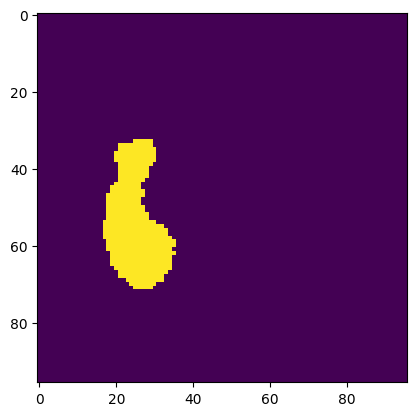

In [43]:
plt.imshow(slice_tumor_mask[..., ::-1])